# Speech Understanding 
# Lecture 7: speech synthesis



### Mark Hasegawa-Johnson, KCGI

In today's lecture, we will learn how to synthesize speech.

Here are the contents:
1. [Voice source](#section1)
1. [Resonance](#section2)
1. [Formant frequencies](#section3)
1. [Homework](#homework)

<a id='section1'></a>

## 1.  Voice source

Voiced speech starts with vibration of the vocal folds.  

It is possible to watch vocal fold vibration by placing a mirror at the back of the throat, like this:  

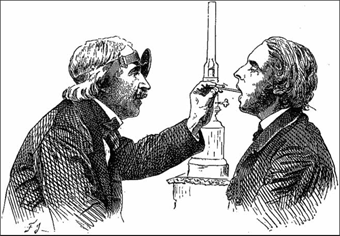

Public Domain image, https://commons.wikimedia.org/w/index.php?curid=1410122

Rather than using a mirror, it's better to use a fiber-optic scope.  With a strobe light, you can get videos like this one.  In this video,

* The vibrating flaps of tissue are called **vocal folds**.  They used to be called vocal cords, but that was a bad name, because as you can see, they are not cords.
* The hole in between the vocal folds is called the **glottis**.  When the glottis is open, it lets air come from the lungs into the throat.
* The vocal folds seem to slow down -- that's because the photographer is using a **strobe light** to slow down the apparent vibration, so that you can see the movement more clearly.

<video width="320" height="240" 
       src="./figs/Stroboscopy_Normal_Female_Vocal_Cords.webm"  
       controls>
</video>

CC-BY 3.0: https://commons.wikimedia.org/wiki/File:Stroboscopy_Normal_Female_Vocal_Cords.webm

When the vocal folds open, they allow air into the vocal tract.  When they close, the airflow suddenly shuts off.  In the image below,

* The top image shows the air **flow**, sometimes called the **glottal wave**. When the vocal folds close, the air flow stops.
* The bottom image shows the air **pressure**, sometimes called the **derivative glottal wave**.  When the air flow suddenly stops, there is a sudden negative spike of air pressure.  This sudden negative air pressure is so important that it has a special name: we call it a **glottal pulse**.

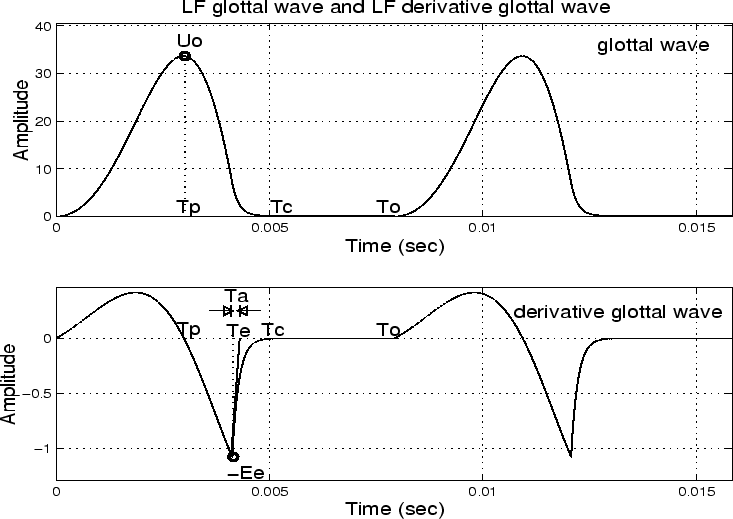

Image Copyright Julius O. Smith III, https://ccrma.stanford.edu/~jos/SMAC03S/Liljencrantz_Fant_Derivative_Glottal_Wave.html

The most important thing to know about anybody's voice is the time between glottal pulses.  This time is called the **pitch period**, $T_0$.  The pitch period is related to the **pitch frequency**, $F_0$, as follows:

$$T_0 \left[\frac{\text{samples}}{\text{pitch period}}\right] = \frac{F_s\left[\frac{\text{samples}}{\text{second}}\right]}{F_0\left[\frac{\text{pitch periods}}{\text{second}}\right]}$$

For example, a typical male baritone speaks with a pitch frequency of $A_2$ (the A note two octaves below middle A).  As you know from last week, the frequency of $A_4$ is $F_0=440$Hz, so the frequency of $A_2$ is $F_0=110$Hz.  The pitch period for a baritone, using an $F_s=8000$Hz sampling rate, would therefore be:

$$T_0 = \frac{F_s}{F_0}=\frac{8000}{110}=72.7\text{samples}$$

We can make a reasonable approximation of baritone voice by creating an excitation signal $e[n]$ such that:

$$e[n]=\left\{\begin{array}{ll}
1 & n~\text{is an integer multiple of}~73\\
0 & \text{otherwise}\end{array}\right.$$

Here is code to do that:

Text(0.5, 1.0, 'The first 300 samples of a simple speech excitation signal')

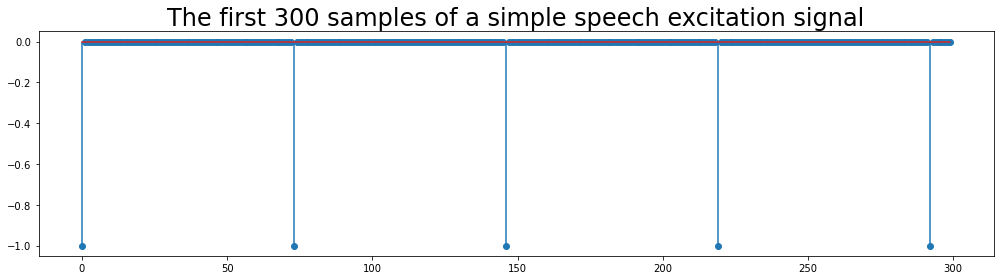

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Fs = 8000
F0 = 110
T0 = int(np.round(Fs/F0))  # rounding will make T0=73

excitation = np.zeros(8000)
excitation[::T0] = -1   # start=0, end=end of array, step=T0 

fig=plt.figure(figsize=(14,4),layout='tight')
subfig=fig.subplots(1,1)
subfig.stem(excitation[:300])  # Plot just the first 300 samples
subfig.set_title('The first 300 samples of a simple speech excitation signal',fontsize=24)

In [3]:
import IPython.display
IPython.display.Audio(data=excitation,rate=Fs)

<a id='section2'></a>

## 2. Resonance

How is the excitation signal, $e[n]$, turned into the speech signal, $s[n]$? 

The answer is: resonance.  The excitation signal goes through the vocal tract, which has resonances, just like a flute has resonances:

$$e[n]\rightarrow\fbox{Resonant Filter}\rightarrow s[n]$$

<img alt="picture of source-filter model of speech" src="figs/334px-Source-filter_model_diagram.svg.png" width="220"/>
CC-SA 4.0: https://commons.wikimedia.org/wiki/File:Source-filter_model_diagram.svg

* The **vocal tract (pharynx and mouth)** is the air cavity between the vocal folds and the lips (lower blue part in the picture above.
* The **nasal tract** is the air cavity through the nose (upper blue part).

Excitation at the vocal folds ($e[n]$) sets up a standing wave in the vocal tract, in which the air molecules bounce back and forth like this:

<img alt="F1 molecules" src="figs/440px-Molecule1.gif" width="220" />

... which generates speech output at the lips, like this:

$$e[n]\rightarrow\fbox{Resonant Filter}\rightarrow s[n]$$

It's possible to imitate resonance using a digital filter with the following structure:

<img alt="digital resonator structure" src="figs/klatt1980fig5a.png">

Image copyright Journal of the Acoustical Society of America, https://pubs.aip.org/asa/jasa/article-abstract/67/3/971/787172/Software-for-a-cascade-parallel-formant?redirectedFrom=fulltext

In the figure above, $T=\frac{1}{F_s}$ is the time per sample (in seconds).  So if we are using a digital filter, the code for a resonator is

$$y[n] = Ax[n]+By[n-1]+Cy[n-2]$$

or 

```
y[n] = A*x[n]+B*y[n-1]+C*y[n-2]
```

where the coefficients $A$, $B$, and $C$ are given in Klatt's 1980 article as:
<img alt="resonator coefficients" src="figs/klatt1980fig5eqs.png">

Let's just re-write those into python:

```
C = -np.exp(-2*np.pi*BW/Fs)
B = 2 * np.exp(-np.pi*BW/Fs) * np.cos(2*np.pi*F/Fs)
A = 1 - B - C
```

In [4]:
def resonator(x, F, BW, Fs):
    C = -np.exp(-2*np.pi*BW/Fs)
    B = 2 * np.exp(-np.pi*BW/Fs) * np.cos(2*np.pi*F/Fs)
    A = 1 - B - C
    y = np.zeros(len(x))
    y[0] = A*x[0]
    y[1] = A*x[1] + B*y[0]
    for n in range(2,len(y)):
        y[n] = A*x[n] + B*y[n-1] + C*y[n-2]
    return y

Text(0.5, 1.0, 'Excitation passed through a 500Hz resonator')

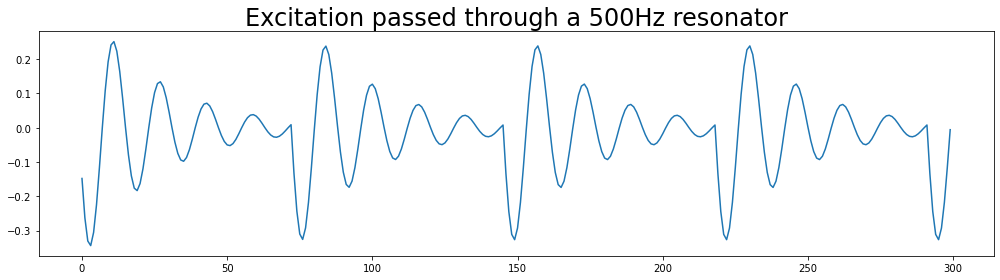

In [5]:
resonance = resonator(excitation, 500, 100, Fs)

fig=plt.figure(figsize=(14,4),layout='tight')
subfig=fig.subplots(1,1)
subfig.plot(resonance[:300])  # Plot just the first 300 samples
subfig.set_title('Excitation passed through a 500Hz resonator',fontsize=24)

In [6]:
import IPython.display
IPython.display.Audio(data=resonance,rate=Fs)

You can hear that the sound has changed, but it doesn't yet sound very speech-like.  To make it sound more speech-like, we need to account for the first four resonant frequencies.  Here is a figure showing the air pressure, the air molecule velocities, and animations of how the air molecules move in each of the first four resonant frequencies.  This table is copied from https://en.wikipedia.org/wiki/Acoustic_resonance because I like it so much.  All of the images are CC-SA 3.0: Lookang.

| Frequency | Velocity of air molecules | Positions of air molecules |
| :-: | :-: | :-: |
| $F_1$ | <img alt="F1 waves" src="figs/440px-Pipe001.gif" width="220" /> | <img alt="F1 molecules" src="figs/440px-Molecule1.gif" width="220" /> |
| $F_2$ | <img alt="F2 waves" src="figs/440px-Pipe002.gif" width="220" /> | <img alt="F2 molecules" src="figs/440px-Molecule2.gif" width="220" /> |
| $F_3$ | <img alt="F3 waves" src="figs/440px-Pipe003.gif" width="220" /> | <img alt="F3 molecules" src="figs/440px-Molecule3.gif" width="220" /> |
| $F_4$ | <img alt="F4 waves" src="figs/440px-Pipe004.gif" width="220" /> | <img alt="F4 molecules" src="figs/440px-Molecule4.gif" width="220" /> |


We can account for all four of those resonances using this system diagram:

$$e[n]\rightarrow
\fbox{$\stackrel{F_1}{\text{resonator}}$}\rightarrow
\fbox{$\stackrel{F_2}{\text{resonator}}$}\rightarrow
\fbox{$\stackrel{F_3}{\text{resonator}}$}\rightarrow
\fbox{$\stackrel{F_4}{\text{resonator}}$}\rightarrow s[n]$$

For an /a/ vowel, for a male speaker, the resonant frequencies and bandwidths are roughly:

| Formant Number | Frequency | Bandwidth |
| :-: | :-: | :-: |
| 1 | 700 | 100 |
| 2 | 1200 | 200 |
| 3 | 2500 | 300 |
| 4 | 3500 | 400 |

So we can synthesize an /a/ like this:

Text(0.5, 1.0, 'Synthesized /a/ vowel')

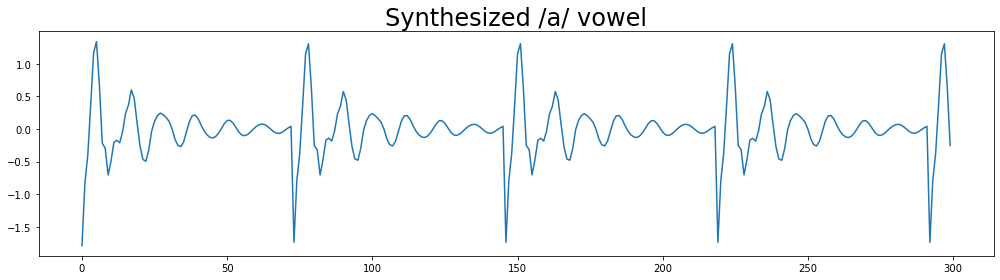

In [7]:
y1 = resonator(excitation, 700, 100, Fs)
y2 = resonator(y1, 1200, 200, Fs)
y3 = resonator(y2, 2500, 300, Fs)
speech = resonator(y3, 3500, 400, Fs)

fig=plt.figure(figsize=(14,4),layout='tight')
subfig=fig.subplots(1,1)
subfig.plot(speech[:300])  # Plot just the first 300 samples
subfig.set_title('Synthesized /a/ vowel',fontsize=24)

In [7]:
import IPython.display
IPython.display.Audio(data=speech,rate=Fs)

<a id='section3'></a>

## 3. Formant frequencies

The voice source just sets the **pitch** of speech.  The type of speech sound is determined by the shape of the vocal tract.

* The **vocal tract** is the air passage between glottis and lips
* The tongue, jaw, lips, and other structures that shape the vocal tract are called **articulators**

You can see how the articulators shape the vocal tract in this real-time MRI video of speech production:

<video width="320" height="240" 
       src="./figs/Real-time_MRI_-_Speaking_(English).ogv"  
       controls>
</video>

CC-SA 3.0: https://en.wikipedia.org/wiki/File:Real-time_MRI_-_Speaking_(English).ogv

When the shape of the vocal tract changes, it changes the **resonant frequencies** of the vocal tract.  The resonant frequencies are also called **formants**.



As the shape of the vocal tract changes, it changes the formant frequencies.  If you know $F_1$, $F_2$, and $F_3$, then you can specify the vowel!  Here is a picture of the formant frequencies $F_1$ and $F_2$ of the vowels in Swedish:

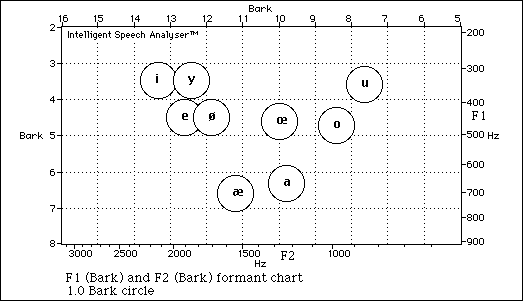

CC-SA 4.0: https://commons.wikimedia.org/wiki/File:F1_and_F2_formant_chart_with_Bark_scale_(3).gif

Notice that this figure only specifies the first two formant **frequencies**, $F_1$ and $F_2$.  It doesn't specify any of the formant **bandwidths**, and it doesn't specify $F_3$ or $F_4$.  It turns out that you can get pretty decent-sounding vowels by only modifying $F_1$ and $F_2$, and leaving the other formants and bandwidth always the same.  Thus:

| Formant Number | Frequency | Bandwidth |
| :-: | :-: | :-: |
| 1 | Depends on the vowel | 100 |
| 2 | Depends on the vowel | 200 |
| 3 | 2500 | 300 |
| 4 | 3500 | 400 |

In [22]:
F1 = {'a':700, 'i':350, 'u':350, 'e':450, 'o':500}
F2 = {'a':1200, 'i':2100, 'u':850, 'e':1900, 'o':950}


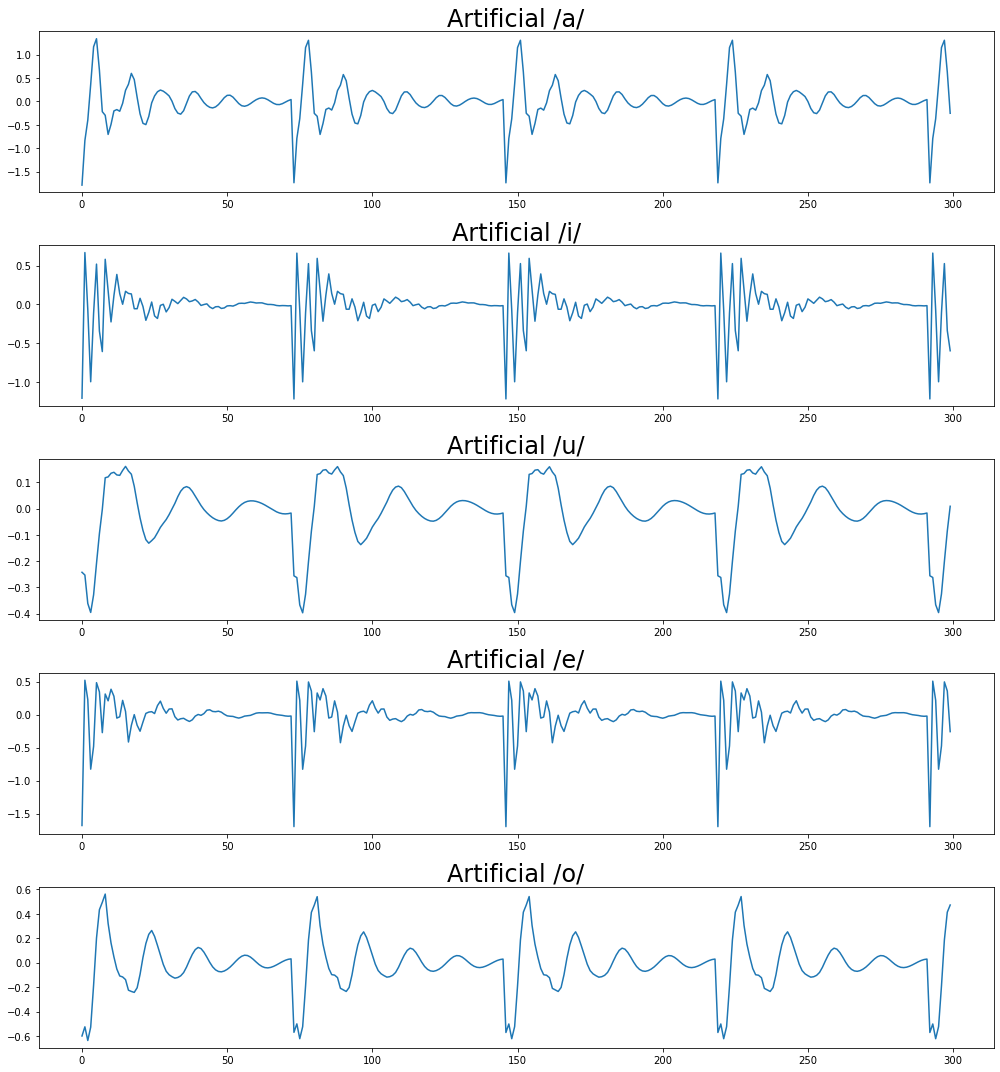

In [23]:
fig = plt.figure(figsize=(14,15),layout='tight')
subfig = fig.subplots(5,1)

speech = np.zeros(0)

for plotnum, phoneme in enumerate('aiueo'):
    y1 = resonator(excitation, F1[phoneme], 100, Fs)
    y2 = resonator(y1, F2[phoneme], 200, Fs)
    y3 = resonator(y2, 2500, 300, Fs)
    y4 = resonator(y3, 3500, 400, Fs)
    
    subfig[plotnum].plot(y4[:300])
    subfig[plotnum].set_title('Artificial /%s/'%(phoneme),fontsize=24)
    speech = np.concatenate((speech,y4,np.zeros(8000)))

In [10]:
IPython.display.Audio(data=speech, rate=Fs)

<a id="homework"></a>

## Homework 

Homework will be graded on Github.com.  In this directory you will find a file called `homework7.py`.  Edit the following functions:

### Homework 7.1: voiced excitation

In [8]:
import homework7, importlib
importlib.reload(homework7)
help(homework7.voiced_excitation)

Help on function voiced_excitation in module homework7:

voiced_excitation(duration, F0, Fs)
    Create voiced speeech excitation.
    
    @param:
    duration (scalar) - length of the excitation, in samples
    F0 (scalar) - pitch frequency, in Hertz
    Fs (scalar) - sampling frequency, in samples/second
    
    @returns:
    excitation (np.ndarray) - the excitation signal, such that
      excitation[n] = -1 if n is an integer multiple of int(np.round(Fs/F0))
      excitation[n] = 0 otherwise



Text(0.5, 1.0, 'The first 300 samples of a simple speech excitation signal')

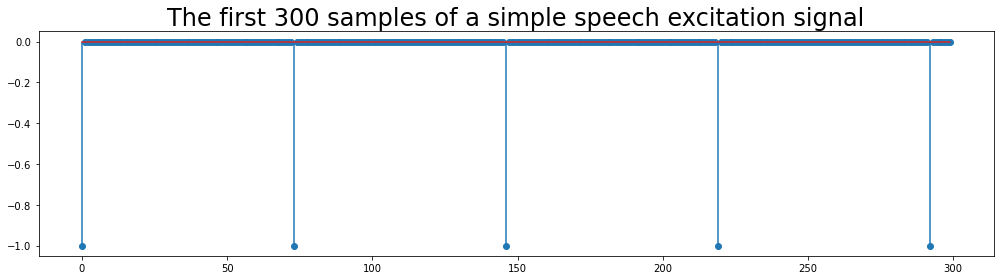

In [9]:
importlib.reload(homework7)
excitation = homework7.voiced_excitation(8000, 110, 8000)

fig=plt.figure(figsize=(14,4),layout='tight')
subfig=fig.subplots(1,1)
subfig.stem(excitation[:300])  # Plot just the first 300 samples
subfig.set_title('The first 300 samples of a simple speech excitation signal',fontsize=24)

### Homework 7.2: resonator

In [13]:
importlib.reload(homework7)
help(homework7.resonator)

Help on function resonator in module homework7:

resonator(x, F, BW, Fs)
    Generate the output of a resonator.
    
    @param:
    x (np.ndarray(N)) - the excitation signal
    F (scalar) - resonant frequency, in Hertz
    BW (scalar) - resonant bandwidth, in Hertz
    Fs (scalar) - sampling frequency, in samples/second
    
    @returns:
    y (np.ndarray(N)) - resonant output



Text(0.5, 1.0, 'Excitation passed through a 500Hz resonator')

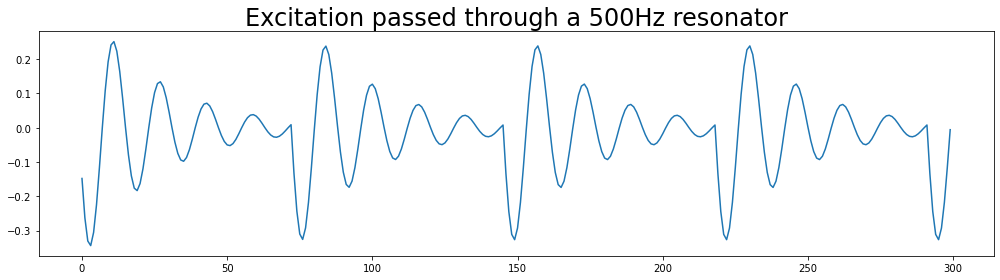

In [14]:
importlib.reload(homework7)

resonance = homework7.resonator(excitation, 500, 100, Fs)

fig=plt.figure(figsize=(14,4),layout='tight')
subfig=fig.subplots(1,1)
subfig.plot(resonance[:300])  # Plot just the first 300 samples
subfig.set_title('Excitation passed through a 500Hz resonator',fontsize=24)

### Homework 7.3: synthesize_vowel

In [19]:
importlib.reload(homework7)
help(homework7.synthesize_vowel)

Help on function synthesize_vowel in module homework7:

synthesize_vowel(duration, F0, F1, F2, F3, F4, BW1, BW2, BW3, BW4, Fs)
    Synthesize a vowel.
    
    @param:
    duration (scalar) - duration in samples
    F0 (scalar) - pitch frequency in Hertz
    F1 (scalar) - first formant frequency in Hertz
    F2 (scalar) - second formant frequency in Hertz
    F3 (scalar) - third formant frequency in Hertz
    F4 (scalar) - fourth formant frequency in Hertz
    BW1 (scalar) - first formant bandwidth in Hertz
    BW2 (scalar) - second formant bandwidth in Hertz
    BW3 (scalar) - third formant bandwidth in Hertz
    BW4 (scalar) - fourth formant bandwidth in Hertz
    Fs (scalar) - sampling frequency in samples/second
    
    @returns:
    speech (np.ndarray(samples)) - synthesized vowel



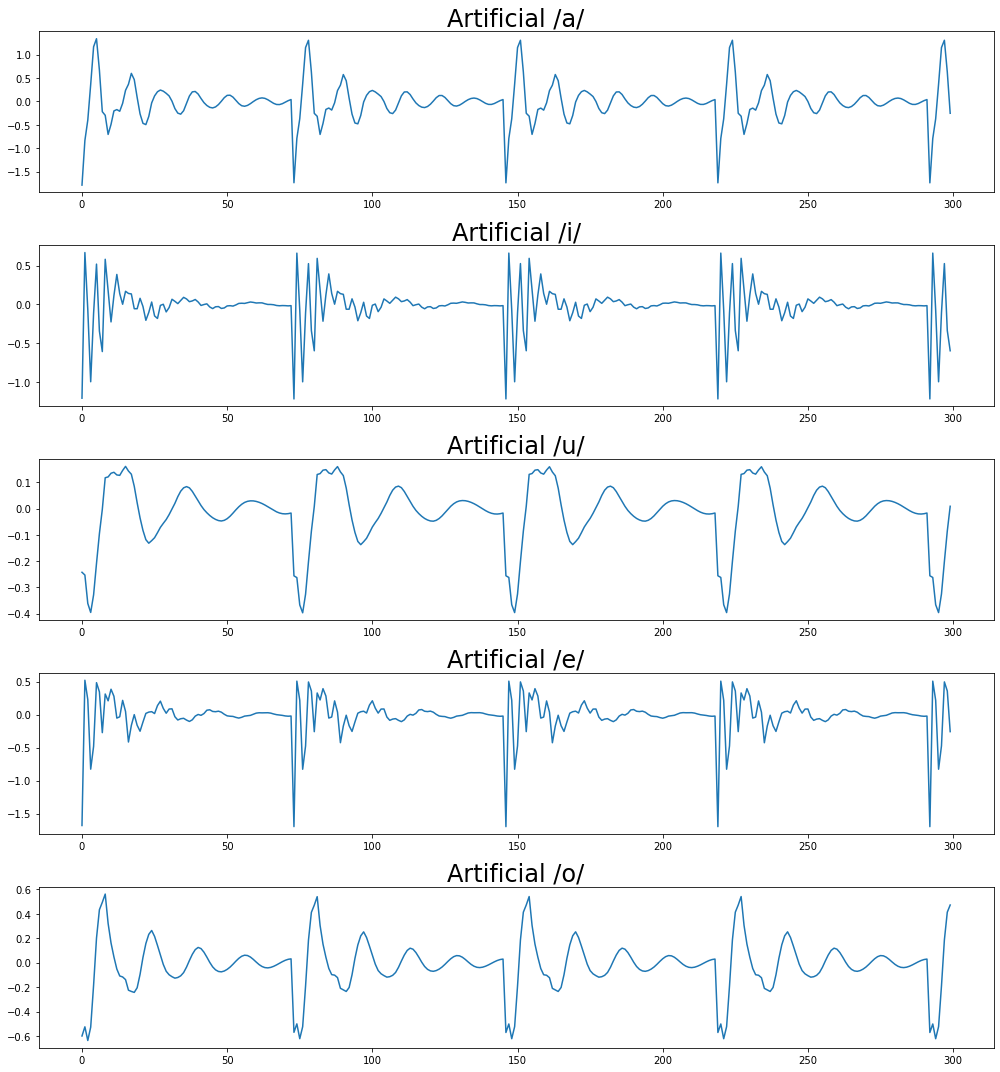

In [24]:
importlib.reload(homework7)

fig = plt.figure(figsize=(14,15),layout='tight')
subfig = fig.subplots(5,1)

speech = np.zeros(0)

for plotnum, phoneme in enumerate('aiueo'):
    speech = homework7.synthesize_vowel(8000,F0,F1[phoneme],F2[phoneme],2500,3500,100,200,300,400,Fs)
    
    subfig[plotnum].plot(speech[:300])
    subfig[plotnum].set_title('Artificial /%s/'%(phoneme),fontsize=24)


### Receiving your grade

In order to receive a grade for your homework, you need to:

1. Run the following code block on your machine.  The result may list some errors, and then in the very last line, it will show a score.  That score (between 0% and 100%) is the grade you have earned so far.  If you want to earn a higher grade, please continue editing `homework3.py`, and then run this code block again.
1. When you are happy with your score (e.g., when it reaches 100%), choose `File` $\Rightarrow$ `Save and Checkpoint`.  Then use `GitHub Desktop` to commit and push your changes.
1. Make sure that the 100% shows on your github repo on github.com.  If it doesn't, you will not receive credit.

In [18]:
import importlib, grade
importlib.reload(grade)

...
----------------------------------------------------------------------
Ran 3 tests in 0.063s

OK


3 successes out of 3 tests run
Score: 100%


<module 'grade' from 'C:\\Users\\User\\Documents\\GitHub\\intro_speech_understanding\\2023_fall\\lec07\\grade.py'>